# Qwen3-VL Embedding Model Examples

This notebook demonstrates how to use the Qwen3-VL embedding model for various tasks:

**Text Tasks**
- Text Classification
- Text Question Answering
- Text Retrieval

**Image Tasks**
- Image Classification
- Image Question Answering
- Image Retrieval

---
# Part 0: Setup

## 0.1 Import Packages

In [1]:
import os
import sys
import json
import torch
import numpy as np
import tempfile
import pickle
import requests
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from datasets import load_dataset, Video, load_from_disk
from PIL import Image
from io import BytesIO
from decord import VideoReader, cpu

## 0.2 Load Embedding Model

In [ ]:
sys.path.append(str(Path("..").resolve()))
from src.models.qwen3_vl_embedding import Qwen3VLEmbedder

MODEL_PATH = r"../models/Qwen3-VL-Embedding-2B" # "your model path"
OUTPUT_DIR = "./retrieval_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

embedder = Qwen3VLEmbedder(
    model_name_or_path=MODEL_PATH,
    max_length=8192,
    max_frames=16,
    fps=1
)

print("Embedding model loaded successfully!")

Embedding model loaded successfully!


## 0.3 Helper Functions

In [3]:
def save_video_temp(video_data):
    """Save video bytes to temporary file."""
    if isinstance(video_data, bytes):
        video_bytes = video_data
    elif hasattr(video_data, 'read'):
        video_bytes = video_data.read()
    elif isinstance(video_data, dict):
        video_bytes = video_data.get('bytes', video_data)
    else:
        video_bytes = video_data
    
    temp_file = tempfile.NamedTemporaryFile(suffix='.mp4', delete=False)
    temp_file.write(video_bytes)
    temp_file.close()
    return temp_file.name

def retrieve_topk(query_embeddings, corpus_embeddings, k=10):
    """Retrieve top-k results based on cosine similarity."""
    similarity_scores = torch.mm(query_embeddings, corpus_embeddings.T)
    results = []
    for i in range(len(query_embeddings)):
        scores = similarity_scores[i].cpu().float().numpy()
        ranked_indices = np.argsort(scores)[::-1][:k]
        ranked_scores = scores[ranked_indices]
        results.append({
            "ranked_indices": ranked_indices.tolist(),
            "ranked_scores": ranked_scores.tolist()
        })
    return results

def encode_corpus(inputs, batch_size=8):
    """Encode corpus in batches."""
    embeddings_list = []
    for i in range(0, len(inputs), batch_size):
        batch = inputs[i:i+batch_size]
        batch_emb = embedder.process(batch)
        embeddings_list.append(batch_emb)
    return torch.cat(embeddings_list, dim=0)

TOP_K = 10

---
# Part 1: Text Tasks

## 1.1 Text Classification

Using [AG News](https://huggingface.co/datasets/ag_news) dataset with 4 categories: World, Sports, Business, Sci/Tech.

In [4]:
# Load dataset
text_cls_dataset = load_dataset("ag_news", split="test[:200]")
TEXT_CLS_LABELS = ["World", "Sports", "Business", "Sci/Tech"]

print(f"Dataset size: {len(text_cls_dataset)}")
print(f"Labels: {TEXT_CLS_LABELS}")

Dataset size: 200
Labels: ['World', 'Sports', 'Business', 'Sci/Tech']


In [5]:
# Encode label corpus
text_cls_corpus_inputs = [{"text": label} for label in TEXT_CLS_LABELS]
text_cls_corpus_embeddings = embedder.process(text_cls_corpus_inputs)
print(f"Label embeddings shape: {text_cls_corpus_embeddings.shape}")

Label embeddings shape: torch.Size([4, 2048])


In [6]:
# Select 2 queries
text_cls_query_indices = [0, 50]
text_cls_queries = [{
    "text": text_cls_dataset[i]["text"],
    "gt_label": TEXT_CLS_LABELS[text_cls_dataset[i]["label"]],
    "gt_idx": text_cls_dataset[i]["label"]
} for i in text_cls_query_indices]

print("Selected queries:")
for i, q in enumerate(text_cls_queries):
    print(f"  {i+1}. [{q['gt_label']}] {q['text']}")

Selected queries:
  1. [Business] Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
  2. [World] US fighter squadron to be deployed in South Korea next month (AFP) AFP - A squadron of US Air Force F-15E fighters based in Alaska will fly to South Korea next month for temporary deployment aimed at enhancing US firepower on the Korean peninsula, US authorities said.


In [7]:
# Encode queries and classify
text_cls_query_inputs = [{"text": q['text'], "instruction": "Classify the news article."} 
                         for q in text_cls_queries]
text_cls_query_embeddings = embedder.process(text_cls_query_inputs)

text_cls_results = retrieve_topk(text_cls_query_embeddings, text_cls_corpus_embeddings, len(TEXT_CLS_LABELS))

# Display results
print("\n" + "=" * 80)
print("TEXT CLASSIFICATION RESULTS")
print("=" * 80)
for i, (q, res) in enumerate(zip(text_cls_queries, text_cls_results)):
    print(f"\nQuery {i+1}: {q['text'][:60]}...")
    print(f"Ground Truth: {q['gt_label']}")
    print("Predictions:")
    for rank, (idx, score) in enumerate(zip(res['ranked_indices'], res['ranked_scores']), 1):
        marker = "✓" if idx == q['gt_idx'] else " "
        print(f"  {rank}. [{marker}] {TEXT_CLS_LABELS[idx]}: {score:.4f}")


TEXT CLASSIFICATION RESULTS

Query 1: Fears for T N pension after talks Unions representing worker...
Ground Truth: Business
Predictions:
  1. [✓] Business: 0.5514
  2. [ ] World: 0.5167
  3. [ ] Sports: 0.4444
  4. [ ] Sci/Tech: 0.3510

Query 2: US fighter squadron to be deployed in South Korea next month...
Ground Truth: World
Predictions:
  1. [✓] World: 0.5738
  2. [ ] Sports: 0.4726
  3. [ ] Business: 0.4319
  4. [ ] Sci/Tech: 0.4236


## 1.2 Text Question Answering

Using [SQuAD](https://huggingface.co/datasets/squad) dataset for passage retrieval given a question.

In [8]:
# Load dataset
text_qa_dataset = load_dataset("squad", split="validation[:100]")

# Build corpus of unique contexts
text_qa_corpus = list(set(text_qa_dataset["context"]))
print(f"Dataset size: {len(text_qa_dataset)}")
print(f"Unique contexts: {len(text_qa_corpus)}")

Dataset size: 100
Unique contexts: 4


In [9]:
# Encode corpus
text_qa_corpus_inputs = [{"text": ctx} for ctx in text_qa_corpus]
text_qa_corpus_embeddings = encode_corpus(text_qa_corpus_inputs, batch_size=8)
print(f"Corpus embeddings shape: {text_qa_corpus_embeddings.shape}")

Corpus embeddings shape: torch.Size([4, 2048])


In [10]:
# Select 2 queries
text_qa_query_indices = [0, 99]
text_qa_queries = [{
    "question": text_qa_dataset[i]["question"],
    "answer": text_qa_dataset[i]["answers"]["text"][0],
    "gt_context": text_qa_dataset[i]["context"],
    "gt_idx": text_qa_corpus.index(text_qa_dataset[i]["context"])
} for i in text_qa_query_indices]

print("Selected queries:")
for i, q in enumerate(text_qa_queries):
    print(f"  {i+1}. Q: {q['question']}")
    print(f"     A: {q['answer']}")

Selected queries:
  1. Q: Which NFL team represented the AFC at Super Bowl 50?
     A: Denver Broncos
  2. Q: Who headlined the halftime show for Super Bowl 50?
     A: Coldplay


In [13]:
# Encode queries and retrieve
text_qa_query_inputs = [{"text": q['question'], "instruction": "Retrieve passages that answer this question."} 
                        for q in text_qa_queries]
text_qa_query_embeddings = embedder.process(text_qa_query_inputs)

text_qa_results = retrieve_topk(text_qa_query_embeddings, text_qa_corpus_embeddings, TOP_K)

# Display results
print("\n" + "=" * 80)
print("TEXT QA RESULTS")
print("=" * 80)
for i, (q, res) in enumerate(zip(text_qa_queries, text_qa_results)):
    print(f"\nQuery {i+1}: {q['question']}")
    print(f"Answer: {q['answer']}")
    print("\nTop-5 Retrieved Passages:")
    for rank, (idx, score) in enumerate(zip(res['ranked_indices'][:5], res['ranked_scores'][:5]), 1):
        marker = "✓" if idx == q['gt_idx'] else " "
        print(f"  {rank}. [{marker}] (score: {score:.4f}) {text_qa_corpus[idx][:200]}...")
    gt_rank = res['ranked_indices'].index(q['gt_idx']) + 1 if q['gt_idx'] in res['ranked_indices'] else -1
    print(f"\nGround Truth Rank: {gt_rank if gt_rank > 0 else 'Not in Top-K'}")


TEXT QA RESULTS

Query 1: Which NFL team represented the AFC at Super Bowl 50?
Answer: Denver Broncos

Top-5 Retrieved Passages:
  1. [✓] (score: 0.8123) Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated...
  2. [ ] (score: 0.6857) The Panthers finished the regular season with a 15–1 record, and quarterback Cam Newton was named the NFL Most Valuable Player (MVP). They defeated the Arizona Cardinals 49–15 in the NFC Championship ...
  3. [ ] (score: 0.6674) The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which th...
  4. [ ] (score: 0.5810) CBS broadcast Super Bowl 50 in the U.S., and charged an average of $5 million for a 30-second commercial during the game. The Super Bowl 50 halftime show was 

## 1.3 Text Retrieval

Using [MS MARCO](https://huggingface.co/datasets/ms_marco) dataset for passage retrieval.

In [14]:
# Load dataset
text_ret_dataset = load_dataset("ms_marco", "v1.1", split="validation[:100]")

# Build corpus
text_ret_corpus = []
for item in text_ret_dataset:
    for passage in item['passages']['passage_text']:
        if passage not in text_ret_corpus:
            text_ret_corpus.append(passage)

print(f"Dataset size: {len(text_ret_dataset)}")
print(f"Corpus size: {len(text_ret_corpus)}")

Dataset size: 100
Corpus size: 821


In [15]:
# Encode corpus
text_ret_corpus_inputs = [{"text": p} for p in text_ret_corpus]
text_ret_corpus_embeddings = encode_corpus(text_ret_corpus_inputs, batch_size=8)
print(f"Corpus embeddings shape: {text_ret_corpus_embeddings.shape}")

Corpus embeddings shape: torch.Size([821, 2048])


In [16]:
# Select 2 queries with relevant passages
text_ret_queries = []
for item in text_ret_dataset:
    if any(item['passages']['is_selected']):
        for p, selected in zip(item['passages']['passage_text'], item['passages']['is_selected']):
            if selected:
                text_ret_queries.append({
                    "query": item['query'],
                    "gt_passage": p,
                    "gt_idx": text_ret_corpus.index(p) if p in text_ret_corpus else -1
                })
                break
    if len(text_ret_queries) >= 2:
        break

print("Selected queries:")
for i, q in enumerate(text_ret_queries):
    print(f"  {i+1}. {q['query']}")

Selected queries:
  1. walgreens store sales average
  2. how much do bartenders make


In [17]:
# Encode queries and retrieve
text_ret_query_inputs = [{"text": q['query'], "instruction": "Retrieve relevant passages."} 
                         for q in text_ret_queries]
text_ret_query_embeddings = embedder.process(text_ret_query_inputs)

text_ret_results = retrieve_topk(text_ret_query_embeddings, text_ret_corpus_embeddings, TOP_K)

# Add metadata
for q, res in zip(text_ret_queries, text_ret_results):
    res['query'] = q['query']
    res['gt_idx'] = q['gt_idx']
    res['gt_passage'] = q['gt_passage']

# Display results
print("\n" + "=" * 80)
print("TEXT RETRIEVAL RESULTS")
print("=" * 80)
for i, (q, res) in enumerate(zip(text_ret_queries, text_ret_results)):
    print(f"\nQuery {i+1}: {q['query']}")
    print(f"Ground Truth: {q['gt_passage'][:80]}...")
    print("\nTop-5 Retrieved Passages:")
    for rank, (idx, score) in enumerate(zip(res['ranked_indices'][:5], res['ranked_scores'][:5]), 1):
        marker = "✓" if idx == q['gt_idx'] else " "
        print(f"  {rank}. [{marker}] (score: {score:.4f}) {text_ret_corpus[idx][:200]}...")
    gt_rank = res['ranked_indices'].index(q['gt_idx']) + 1 if q['gt_idx'] in res['ranked_indices'] else -1
    print(f"\nGround Truth Rank: {gt_rank if gt_rank > 0 else 'Not in Top-K'}")


TEXT RETRIEVAL RESULTS

Query 1: walgreens store sales average
Ground Truth: The average Walgreens salary ranges from approximately $15,000 per year for Cust...

Top-5 Retrieved Passages:
  1. [ ] (score: 0.7988) th store in 1984, reaching $4 billion in sales in 1987, and $5 billion two years later. Walgreens ended the 1980s with 1,484 stores, $5.3 billion in revenues and $154 million in profits. However, prof...
  2. [ ] (score: 0.7901) The number of Walgreen stores has risen from 5,000 in 2005 to more than 8,000 at present. The average square footage per store stood at approximately 10,200 and we forecast the figure to remain consta...
  3. [✓] (score: 0.7709) The average Walgreens salary ranges from approximately $15,000 per year for Customer Service Associate / Cashier to $179,900 per year for District Manager. Average Walgreens hourly pay ranges from app...
  4. [ ] (score: 0.7281) In fiscal 2014, Walgreens opened a total of 184 new locations and acquired 84 locations, for a net 

In [18]:
# Save for reranker
text_save_data = {"corpus": text_ret_corpus, "results": text_ret_results}
with open(os.path.join(OUTPUT_DIR, "text_retrieval_results.pkl"), "wb") as f:
    pickle.dump(text_save_data, f)
print(f"Saved to {OUTPUT_DIR}/text_retrieval_results.pkl")

Saved to ./retrieval_results/text_retrieval_results.pkl


---
# Part 2: Image Tasks

## 2.1 Image Classification

Using [CIFAR-10](https://huggingface.co/datasets/cifar10) dataset with 10 categories.

In [19]:
# Load dataset
image_cls_dataset = load_dataset("cifar10", split="test[:100]")
IMAGE_CLS_LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Dataset size: {len(image_cls_dataset)}")
print(f"Labels: {IMAGE_CLS_LABELS}")

Dataset size: 100
Labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [20]:
# Encode label corpus
image_cls_corpus_inputs = [{"text": label} for label in IMAGE_CLS_LABELS]
image_cls_corpus_embeddings = embedder.process(image_cls_corpus_inputs)
print(f"Label embeddings shape: {image_cls_corpus_embeddings.shape}")

Label embeddings shape: torch.Size([10, 2048])


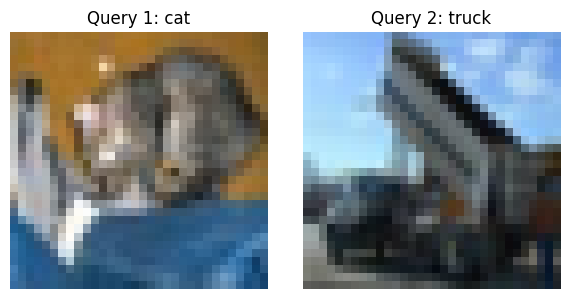

In [21]:
# Select 2 queries
image_cls_query_indices = [0, 50]
image_cls_queries = [{
    "image": image_cls_dataset[i]['img'],
    "gt_label": IMAGE_CLS_LABELS[image_cls_dataset[i]['label']],
    "gt_idx": image_cls_dataset[i]['label']
} for i in image_cls_query_indices]

# Display query images
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, (ax, q) in enumerate(zip(axes, image_cls_queries)):
    ax.imshow(q['image'])
    ax.set_title(f"Query {i+1}: {q['gt_label']}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [22]:
# Encode queries and classify
image_cls_query_inputs = [{"image": q['image'], "instruction": "Classify the object in this image."} 
                          for q in image_cls_queries]
image_cls_query_embeddings = embedder.process(image_cls_query_inputs)

image_cls_results = retrieve_topk(image_cls_query_embeddings, image_cls_corpus_embeddings, len(IMAGE_CLS_LABELS))

# Display results
print("\n" + "=" * 80)
print("IMAGE CLASSIFICATION RESULTS")
print("=" * 80)
for i, (q, res) in enumerate(zip(image_cls_queries, image_cls_results)):
    print(f"\nQuery {i+1} - Ground Truth: {q['gt_label']}")
    print("Predictions:")
    for rank, (idx, score) in enumerate(zip(res['ranked_indices'][:5], res['ranked_scores'][:5]), 1):
        marker = "✓" if idx == q['gt_idx'] else " "
        print(f"  {rank}. [{marker}] {IMAGE_CLS_LABELS[idx]}: {score:.4f}")


IMAGE CLASSIFICATION RESULTS

Query 1 - Ground Truth: cat
Predictions:
  1. [✓] cat: 0.6659
  2. [ ] dog: 0.5833
  3. [ ] bird: 0.5377
  4. [ ] frog: 0.4861
  5. [ ] deer: 0.4817

Query 2 - Ground Truth: truck
Predictions:
  1. [✓] truck: 0.6927
  2. [ ] automobile: 0.5812
  3. [ ] ship: 0.5683
  4. [ ] airplane: 0.4774
  5. [ ] bird: 0.4563


## 2.2 Image Question Answering

Using [VQAv2](https://huggingface.co/datasets/lmms-lab/VQAv2) dataset.

In [23]:
# Load dataset - use validation split which has answers
image_qa_dataset = load_dataset("lmms-lab/VQAv2", split="validation[:200]")

# Build answer corpus
all_answers = []
for item in image_qa_dataset:
    if item['answers'] is not None:  # 添加安全检查
        all_answers.extend([ans['answer'] for ans in item['answers']])

image_qa_corpus = [ans for ans, _ in Counter(all_answers).most_common(50)]

print(f"Dataset size: {len(image_qa_dataset)}")
print(f"Answer corpus size: {len(image_qa_corpus)}")

Dataset size: 200
Answer corpus size: 50


In [24]:
# Encode answer corpus
image_qa_corpus_inputs = [{"text": ans} for ans in image_qa_corpus]
image_qa_corpus_embeddings = encode_corpus(image_qa_corpus_inputs, batch_size=16)
print(f"Answer embeddings shape: {image_qa_corpus_embeddings.shape}")

Answer embeddings shape: torch.Size([50, 2048])


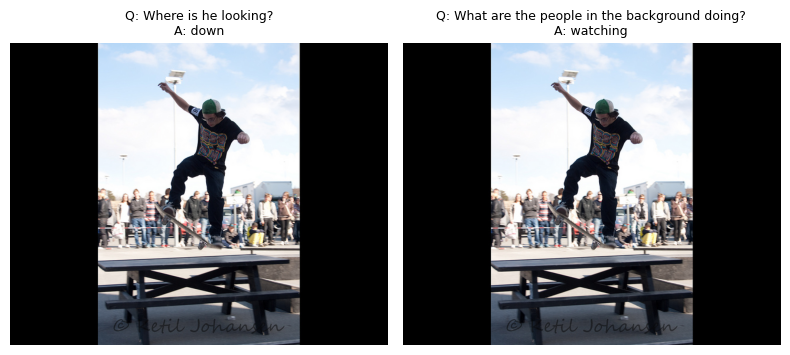

In [25]:
# Select 2 queries whose answers are in corpus
image_qa_queries = []
for item in image_qa_dataset:
    gt_answers = [ans['answer'] for ans in item['answers']]
    most_common = Counter(gt_answers).most_common(1)[0][0]
    if most_common in image_qa_corpus:
        image_qa_queries.append({
            "image": item['image'],
            "question": item['question'],
            "gt_answer": most_common,
            "gt_idx": image_qa_corpus.index(most_common)
        })
    if len(image_qa_queries) >= 2:
        break

# Display queries
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i, (ax, q) in enumerate(zip(axes, image_qa_queries)):
    ax.imshow(q['image'])
    ax.set_title(f"Q: {q['question']}\nA: {q['gt_answer']}", fontsize=9)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [26]:
# Encode queries and retrieve
image_qa_query_inputs = [{
    "image": q['image'], 
    "text": q['question'],
    "instruction": "Find the answer to this question about the image."
} for q in image_qa_queries]
image_qa_query_embeddings = embedder.process(image_qa_query_inputs)

image_qa_results = retrieve_topk(image_qa_query_embeddings, image_qa_corpus_embeddings, TOP_K)

# Display results
print("\n" + "=" * 80)
print("IMAGE QA RESULTS")
print("=" * 80)
for i, (q, res) in enumerate(zip(image_qa_queries, image_qa_results)):
    print(f"\nQuery {i+1}: {q['question']}")
    print(f"Ground Truth: {q['gt_answer']}")
    print("\nTop-5 Answers:")
    for rank, (idx, score) in enumerate(zip(res['ranked_indices'][:5], res['ranked_scores'][:5]), 1):
        marker = "✓" if idx == q['gt_idx'] else " "
        print(f"  {rank}. [{marker}] {image_qa_corpus[idx]}: {score:.4f}")
    gt_rank = res['ranked_indices'].index(q['gt_idx']) + 1 if q['gt_idx'] in res['ranked_indices'] else -1
    print(f"\nGround Truth Rank: {gt_rank if gt_rank > 0 else 'Not in Top-K'}")


IMAGE QA RESULTS

Query 1: Where is he looking?
Ground Truth: down

Top-5 Answers:
  1. [✓] down: 0.5368
  2. [ ] watching: 0.4010
  3. [ ] net: 0.3859
  4. [ ] ball: 0.3656
  5. [ ] exit: 0.3623

Ground Truth Rank: 1

Query 2: What are the people in the background doing?
Ground Truth: watching

Top-5 Answers:
  1. [✓] watching: 0.6721
  2. [ ] snowboarding: 0.3304
  3. [ ] fence: 0.2965
  4. [ ] none: 0.2842
  5. [ ] women: 0.2827

Ground Truth Rank: 1


## 2.3 Image Retrieval

Using [COCO](https://huggingface.co/datasets/yerevann/coco-karpathy) dataset for text-to-image retrieval.

In [27]:
# Load dataset
image_ret_dataset = load_dataset("yerevann/coco-karpathy", split="test[:10]")

image_ret_corpus = []
image_ret_captions = []
for item in image_ret_dataset:
    resp = requests.get(item['url'])
    resp.raise_for_status()
    image_ret_corpus.append(Image.open(BytesIO(resp.content)))
    image_ret_captions.append(item['sentences'][0])# Take first caption

print(f"Image corpus size: {len(image_ret_corpus)}")

Image corpus size: 10


In [28]:
# Encode image corpus
image_ret_corpus_inputs = [{"image": img} for img in image_ret_corpus]
image_ret_corpus_embeddings = encode_corpus(image_ret_corpus_inputs, batch_size=4)
print(f"Image embeddings shape: {image_ret_corpus_embeddings.shape}")

Image embeddings shape: torch.Size([10, 2048])


In [29]:
# Select 2 queries
image_ret_query_indices = [0, 9]
image_ret_queries = [{
    "caption": image_ret_captions[i],
    "gt_idx": i
} for i in image_ret_query_indices]

print("Selected queries:")
for i, q in enumerate(image_ret_queries):
    print(f"  {i+1}. {q['caption']}")

Selected queries:
  1. A man with a red helmet on a small moped on a dirt road. 
  2. The bathroom is clean and ready to be used. 



IMAGE RETRIEVAL RESULTS

Query 1: A man with a red helmet on a small moped on a dirt road. 


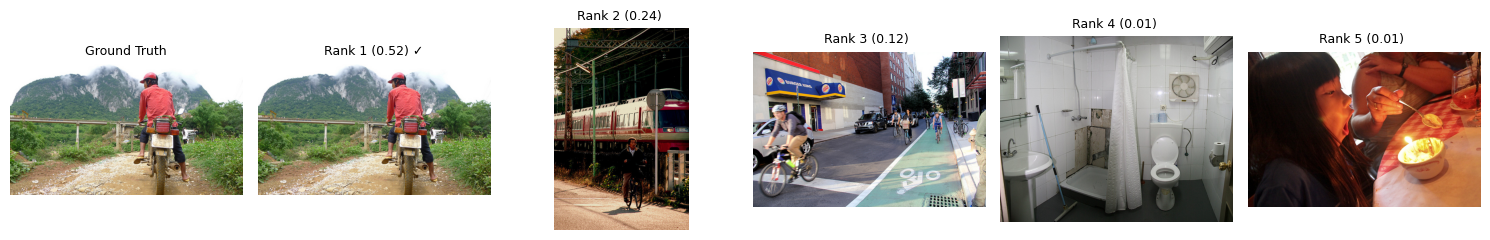

Ground Truth Rank: 1

Query 2: The bathroom is clean and ready to be used. 


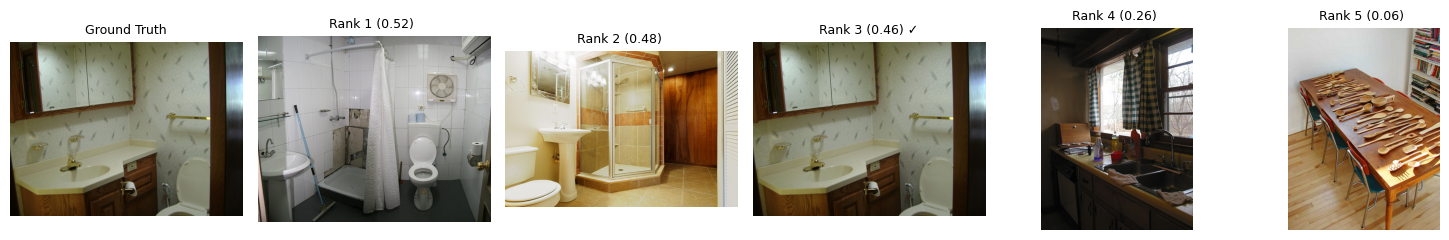

Ground Truth Rank: 3


In [33]:
# Encode queries and retrieve
image_ret_query_inputs = [{"text": q['caption'], "instruction": "Find images matching this description."} 
                          for q in image_ret_queries]
image_ret_query_embeddings = embedder.process(image_ret_query_inputs)

image_ret_results = retrieve_topk(image_ret_query_embeddings, image_ret_corpus_embeddings, TOP_K)

# Add metadata
for q, res in zip(image_ret_queries, image_ret_results):
    res['caption'] = q['caption']
    res['gt_idx'] = q['gt_idx']

# Display results
print("\n" + "=" * 80)
print("IMAGE RETRIEVAL RESULTS")
print("=" * 80)
for i, (q, res) in enumerate(zip(image_ret_queries, image_ret_results)):
    print(f"\nQuery {i+1}: {q['caption']}")
    
    fig, axes = plt.subplots(1, 6, figsize=(15, 2.5))
    axes[0].imshow(image_ret_corpus[q['gt_idx']])
    axes[0].set_title("Ground Truth", fontsize=9)
    axes[0].axis('off')
    
    for rank, (ax, idx, score) in enumerate(zip(axes[1:], res['ranked_indices'][:5], res['ranked_scores'][:5]), 1):
        ax.imshow(image_ret_corpus[idx])
        marker = "✓" if idx == q['gt_idx'] else ""
        ax.set_title(f"Rank {rank} ({score:.2f}) {marker}", fontsize=9)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    gt_rank = res['ranked_indices'].index(q['gt_idx']) + 1 if q['gt_idx'] in res['ranked_indices'] else -1
    print(f"Ground Truth Rank: {gt_rank if gt_rank > 0 else 'Not in Top-K'}")

In [31]:
# Save for reranker
image_save_dir = os.path.join(OUTPUT_DIR, "images")
os.makedirs(image_save_dir, exist_ok=True)

image_paths = []
for idx, img in enumerate(image_ret_corpus):
    path = os.path.join(image_save_dir, f"img_{idx}.jpg")
    img.save(path)
    image_paths.append(path)

image_save_data = {"corpus_paths": image_paths, "captions": image_ret_captions, "results": image_ret_results}
with open(os.path.join(OUTPUT_DIR, "image_retrieval_results.pkl"), "wb") as f:
    pickle.dump(image_save_data, f)
print(f"Saved to {OUTPUT_DIR}/image_retrieval_results.pkl")

Saved to ./retrieval_results/image_retrieval_results.pkl
